In [8]:
# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

from sklearn.utils.extmath import _ravel

# random seed 
RS=20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [3]:
digits = load_digits()
digits.data.shape
# print(digits['DESCR'])

(1797, 64)

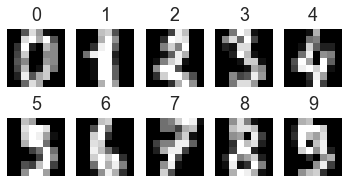

In [5]:
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])

In [6]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])
digits_proj = TSNE(random_state=RS).fit_transform(X)

(<matplotlib.figure.Figure at 0xdaaaa58>,
  <matplotlib.text.Text at 0xc3d5518>])

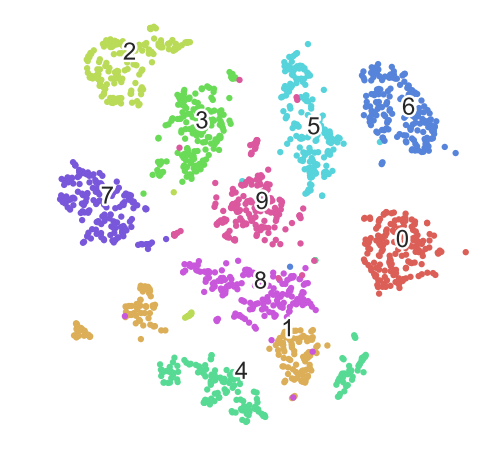

In [12]:
def scatter(x, colors):
    
    """ TSNE scatterplot """
    
    # seaborn palette
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

scatter(digits_proj, y)

In [14]:
positions = []


def _gradient_descent(objective, p0, it, n_iter, objective_error=None,
                      n_iter_check=1, n_iter_without_progress=50,
                      momentum=0.5, learning_rate=1000.0, min_gain=0.01,
                      min_grad_norm=1e-7, min_error_diff=1e-7, verbose=0,
                      args=None, kwargs=None):

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = 0

    for i in range(it, n_iter):
        # We save the current position.
        positions.append(p.copy())
        
        new_error, grad = objective(p, *args, **kwargs)
        inc = update * grad >= 0.0
        dec = np.invert(inc)
        gains[inc] += 0.05
        gains[dec] *= 0.95
        np.clip(gains, min_gain, np.inf)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
        
        if (i + 1) % n_iter_check == 0:
            if (i + 1) % n_iter_check == 0:
                if new_error is None:
                    new_error = objective_error(p, *args)
                error_diff = np.abs(new_error - error)
                error = new_error
                
                if verbose >= 2:
                    m = "[t-SNE] Iteration %d: error = %.7f, gradient norm = %.7f"
                    print(m % (i + 1, error, grad_norm))
                    
                if error < best_error:
                    best_error = error
                    best_iter = i
                
                elif i - best_iter > n_iter_without_progress:
                    if verbose >= 2:
                        print("[t-SNE] Iteration %d: did not make any progress "
                              "during the last %d episodes. Finished."
                              % (i + 1, n_iter_without_progress))
                    break

                    if grad_norm <= min_grad_norm:
                        if verbose >= 2:
                            print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                                  % (i + 1, grad_norm))
                        break
                        
                    if error_diff <= min_error_diff:
                        if verbose >= 2:
                            m = "[t-SNE] Iteration %d: error difference %f. Finished."
                            print(m % (i + 1, error_diff))
                        break
                
        if new_error is not None:
            error = new_error
        
    return p, error, i

In [15]:
sklearn.manifold.t_sne._gradient_descent = _gradient_descent
X_proj = TSNE(random_state=RS).fit_transform(X)

In [16]:
X_iter = np.dstack(position.reshape(-1, 2) for position in positions)

In [18]:
f, ax, sc, txts = scatter(X_iter[..., -1], y)

def make_frame_mpl(t):
    i = int(t*40)
    x = X_iter[..., i]
    sc.set_offsets(x)
    for j, txt in zip(range(10), txts):
        xtext, ytext = np.median(x[y == j, :], axis=0)
        txt.set_x(xtext)
        txt.set_y(ytext)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)

animation.write_gif("animation-94a2c1ff.gif", fps=20)


[MoviePy] Building file C:/Users/Aleksandr.Turutin/PycharmProjects/python_machine_learning/visualization_snippets/animation-94a2c1ff.gif with imageio


  0%|                                                  | 0/126 [00:00<?, ?it/s]

  2%|█                                         | 3/126 [00:00<00:05, 24.39it/s]

  5%|██                                        | 6/126 [00:00<00:05, 22.93it/s]

  7%|███                                       | 9/126 [00:00<00:05, 22.31it/s]

  9%|███▌                                     | 11/126 [00:00<00:05, 20.76it/s]

 10%|████▏                                    | 13/126 [00:00<00:05, 19.73it/s]

 12%|████▉                                    | 15/126 [00:00<00:05, 18.81it/s]

 13%|█████▌                                   | 17/126 [00:00<00:05, 18.21it/s]

 15%|██████▏                                  | 19/126 [00:00<00:05, 18.20it/s]

 17%|██████▊                                  | 21/126 [00:01<00:05, 17.62it/s]

 18%|███████▍                                 | 23/126 [00:01<00:05, 17.78it/s]

 20%|████████▏                                | 25/126 [00:01<00:05, 17.85it/s]

 21%|████████▊                                | 27/126 [00:01<00:05, 17.80it/s]

 23%|█████████▍                               | 29/126 [00:01<00:05, 18.01it/s]

 25%|██████████                               | 31/126 [00:01<00:05, 18.26it/s]

 26%|██████████▋                              | 33/126 [00:01<00:05, 18.44it/s]

 28%|███████████▍                             | 35/126 [00:01<00:04, 18.51it/s]

 29%|████████████                             | 37/126 [00:01<00:04, 18.62it/s]

 31%|████████████▋                            | 39/126 [00:02<00:04, 18.59it/s]

 33%|█████████████▎                           | 41/126 [00:02<00:04, 18.62it/s]

 34%|█████████████▉                           | 43/126 [00:02<00:04, 18.59it/s]

 36%|██████████████▋                          | 45/126 [00:02<00:04, 18.83it/s]

 37%|███████████████▎                         | 47/126 [00:02<00:04, 18.68it/s]

 39%|███████████████▉                         | 49/126 [00:02<00:04, 18.68it/s]

 40%|████████████████▌                        | 51/126 [00:02<00:04, 18.74it/s]

 42%|█████████████████▏                       | 53/126 [00:02<00:03, 18.72it/s]

 44%|█████████████████▉                       | 55/126 [00:02<00:03, 18.71it/s]

 45%|██████████████████▌                      | 57/126 [00:03<00:03, 18.60it/s]

 47%|███████████████████▏                     | 59/126 [00:03<00:03, 18.58it/s]

 48%|███████████████████▊                     | 61/126 [00:03<00:03, 18.61it/s]

 50%|████████████████████▌                    | 63/126 [00:03<00:03, 18.58it/s]

 52%|█████████████████████▏                   | 65/126 [00:03<00:03, 18.61it/s]

 53%|█████████████████████▊                   | 67/126 [00:03<00:03, 18.43it/s]

 55%|██████████████████████▍                  | 69/126 [00:03<00:03, 18.46it/s]

 56%|███████████████████████                  | 71/126 [00:03<00:02, 18.47it/s]

 58%|███████████████████████▊                 | 73/126 [00:03<00:02, 18.44it/s]

 60%|████████████████████████▍                | 75/126 [00:04<00:02, 18.46it/s]

 61%|█████████████████████████                | 77/126 [00:04<00:02, 18.53it/s]

 63%|█████████████████████████▋               | 79/126 [00:04<00:02, 18.47it/s]

 64%|██████████████████████████▎              | 81/126 [00:04<00:02, 18.44it/s]

 66%|███████████████████████████              | 83/126 [00:04<00:02, 18.51it/s]

 67%|███████████████████████████▋             | 85/126 [00:04<00:02, 18.51it/s]

 69%|████████████████████████████▎            | 87/126 [00:04<00:02, 18.57it/s]

 71%|████████████████████████████▉            | 89/126 [00:04<00:02, 18.45it/s]

 72%|█████████████████████████████▌           | 91/126 [00:04<00:01, 18.52it/s]

 74%|██████████████████████████████▎          | 93/126 [00:04<00:01, 18.52it/s]

 75%|██████████████████████████████▉          | 95/126 [00:05<00:01, 18.47it/s]

 77%|███████████████████████████████▌         | 97/126 [00:05<00:01, 18.58it/s]

 79%|████████████████████████████████▏        | 99/126 [00:05<00:01, 18.56it/s]

 80%|████████████████████████████████        | 101/126 [00:05<00:01, 18.40it/s]

 82%|████████████████████████████████▋       | 103/126 [00:05<00:01, 18.18it/s]

 83%|█████████████████████████████████▎      | 105/126 [00:05<00:01, 18.23it/s]

 85%|█████████████████████████████████▉      | 107/126 [00:05<00:01, 18.27it/s]

 87%|██████████████████████████████████▌     | 109/126 [00:05<00:00, 18.34it/s]

 88%|███████████████████████████████████▏    | 111/126 [00:05<00:00, 18.29it/s]

 90%|███████████████████████████████████▊    | 113/126 [00:06<00:00, 18.36it/s]

 91%|████████████████████████████████████▌   | 115/126 [00:06<00:00, 18.41it/s]

 93%|█████████████████████████████████████▏  | 117/126 [00:06<00:00, 18.34it/s]

 94%|█████████████████████████████████████▊  | 119/126 [00:06<00:00, 18.34it/s]

 96%|██████████████████████████████████████▍ | 121/126 [00:06<00:00, 18.39it/s]

 98%|███████████████████████████████████████ | 123/126 [00:06<00:00, 18.48it/s]

 99%|███████████████████████████████████████▋| 125/126 [00:06<00:00, 18.49it/s]